In [65]:
import pandas as pd
import numpy as np
from utils import *
import pytensor.tensor as pt  # Import PyTensor (Theano backend)

In [66]:
df = read_dd_data('../data/PD_data')

# Extract participant information
participants = df["participant"].unique()
n_participants = len(participants)

# Convert participant IDs to integer indices
participant_idx = {pid: i for i, pid in enumerate(participants)}
df["participant_idx"] = df["participant"].map(participant_idx)

'''
Because of the different levels of magnitude
we decide to standarize rewards and reaction times
'''

# used later for unscaling
# scaling_factors = {
#     "rt_mean": df['rt'].mean(), "rt_std": df['rt'].std(),
#     "rcert_mean": df['rcert'].mean(), "rcert_std": df['rcert'].std(),
#     "runcert_mean": df['runcert'].mean(), "runcert_std": df['runcert'].std()
# }

# df["rcert"] = (df["rcert"] - scaling_factors["rcert_mean"]) / scaling_factors["rcert_std"]
# df["runcert"] = (df["runcert"] - scaling_factors["runcert_mean"]) / scaling_factors["runcert_std"]
# df["rt"] = (df["rt"] - scaling_factors["rt_mean"]) / scaling_factors["rt_std"]

'\nBecause of the different levels of magnitude\nwe decide to standarize rewards and reaction times\n'

In [67]:
# Load the saved trace
import xarray as xr
trace = xr.open_dataset("probabilistic_discounting_trace.nc")
trace

<xarray.Dataset> Size: 1GB
Dimensions:                      (prob_choose_uncertain_dim_0: 9749,
                                  mu_RT_dim_0: 9749, draw: 2000,
                                  k_raw_dim_0: 49, beta0_dim_0: 49,
                                  lambda_raw_dim_0: 49, beta_dim_0: 49,
                                  beta1_dim_0: 49, sigma_RT_dim_0: 49,
                                  k_dim_0: 49, loss_aversion_dim_0: 49, chain: 4)
Coordinates:
  * prob_choose_uncertain_dim_0  (prob_choose_uncertain_dim_0) int32 39kB 0 ....
  * mu_RT_dim_0                  (mu_RT_dim_0) int32 39kB 0 1 2 ... 9747 9748
  * draw                         (draw) int32 8kB 0 1 2 3 ... 1997 1998 1999
  * k_raw_dim_0                  (k_raw_dim_0) int32 196B 0 1 2 3 ... 46 47 48
  * beta0_dim_0                  (beta0_dim_0) int32 196B 0 1 2 3 ... 46 47 48
  * lambda_raw_dim_0             (lambda_raw_dim_0) int32 196B 0 1 2 ... 47 48
  * beta_dim_0                   (beta_dim_0) int32 196B 0 1 2 3 ... 45 46 47 48
  * beta1_dim_0                  (beta1_dim_0) int32 196B 0 1 2 3 ... 46 47 48
  * sigma_RT_dim_0               (sigma_RT_dim_0) int32 196B 0 1 2 ... 46 47 48
  * k_dim_0                      (k_dim_0) int32 196B 0 1 2 3 4 ... 45 46 47 48
  * loss_aversion_dim_0          (loss_aversion_dim_0) int32 196B 0 1 ... 47 48
  * chain                        (chain) int32 16B 0 1 2 3
Data variables: (12/23)
    prob_choose_uncertain        (chain, draw, prob_choose_uncertain_dim_0) float64 624MB ...
    mu_RT                        (chain, draw, mu_RT_dim_0) float64 624MB ...
    k_raw                        (chain, draw, k_raw_dim_0) float64 3MB ...
    beta0                        (chain, draw, beta0_dim_0) float64 3MB ...
    lambda_raw                   (chain, draw, lambda_raw_dim_0) float64 3MB ...
    beta                         (chain, draw, beta_dim_0) float64 3MB ...
    ...                           ...
    mu_beta1                     (chain, draw) float64 64kB ...
    sigma_beta1                  (chain, draw) float64 64kB ...
    mu_sigma_RT                  (chain, draw) float64 64kB ...
    sigma_sigma_RT               (chain, draw) float64 64kB ...
    sigma_lambda                 (chain, draw) float64 64kB ...
    sigma_k                      (chain, draw) float64 64kB ...
Attributes:
    created_at:                 2025-02-22T11:51:41.850535
    arviz_version:              0.17.1
    inference_library:          pymc
    inference_library_version:  5.20.1
    sampling_time:              1075.914027929306
    tuning_steps:               1000

In [68]:
def predict_choice_and_rt_per_participant(trace, df):
    """
    Predict choice probabilities and reaction times for each participant using posterior parameters.
    Compare predictions against ground truth data.
    
    Parameters:
    -----------
    trace : xarray.Dataset
        Dataset containing posterior samples
    df : pandas.DataFrame
        DataFrame containing the experimental data with columns:
        rcert, runcert, event_prob, choice, rt, participant_idx
        
    Returns:
    --------
    dict
        Dictionary containing predictions and metrics for each participant:
        {
            participant_idx: {
                'choice_prob': probability of choosing uncertain option,
                'choice_accuracy': accuracy of choice predictions,
                'rt_pred': predicted reaction time,
                'rt_mse': mean squared error of RT predictions,
                'rt_std': standard deviation of RT prediction
            }
        }
    """
    predictions = {}
    decision_difficulty_choice = {}
    
    # For each unique participant
    for p_idx in df['participant_idx'].unique():
        # Get data for this participant
        p_data = df[df['participant_idx'] == p_idx]
        
        # Extract posterior samples for this participant
        # extract median across chains and draws
        # TODO: use the whole values for uncertainty estimation
        k_samples = trace.k.median(dim=['chain', 'draw']).values
        k_samples = k_samples[p_idx]
        beta_samples = trace.beta.median(dim=['chain', 'draw']).values
        beta_samples = beta_samples[p_idx]
        beta0_samples = trace.beta0.median(dim=['chain', 'draw']).values
        beta0_samples = beta0_samples[p_idx]
        beta1_samples = trace.beta1.median(dim=['chain', 'draw']).values
        beta1_samples = beta1_samples[p_idx]
        sigma_rt_samples = trace.sigma_RT.median(dim=['chain', 'draw']).values
        sigma_rt_samples = sigma_rt_samples[p_idx]
        lambda_samples = trace.loss_aversion.median(dim=['chain', 'draw']).values
        lambda_samples = lambda_samples[p_idx]
        # print(
        #     f"k: {k_samples:.3f}\n"
        #     f"beta: {beta_samples:.3f}\n"
        #     f"beta0: {beta0_samples:.3f}\n" 
        #     f"beta1: {beta1_samples:.3f}\n"
        #     f"sigma_RT: {sigma_rt_samples:.3f}"
        # )

        # print("--------------------------------")
        # Calculate subjective values using hyperbolic discounting

        gains_mask = p_data['condition'] == 1

        SV_certain = np.where(gains_mask,
                            p_data['rcert'].values,
                            -lambda_samples * p_data['rcert'].values)
        
        SV_uncertain = np.where(gains_mask,
                              p_data['runcert'].values / (1 + k_samples * p_data['event_prob'].values),
                              -lambda_samples * p_data['runcert'].values / (1 + k_samples * p_data['event_prob'].values))
        
        # SV_certain = p_data['rcert'].values
        # SV_uncertain = p_data['runcert'].values / (1 + k_samples * p_data['event_prob'].values)
        
        # Calculate value differences
        value_diff = SV_uncertain - SV_certain
        
        # Predict choice probabilities using logistic function
        exp = beta_samples * value_diff
        exp = np.clip(exp, -10, 10)  # Clip to avoid numerical issues
        choice_probs = 1 / (1 + np.exp(-exp))
        
        # Calculate decision difficulty for RT prediction
        decision_difficulty = value_diff ** 2

        # # Decision difficulty incorporating loss aversion
        # decision_difficulty = np.where(gains_mask,
        #                              value_diff ** 2,
        #                              (lambda_samples * value_diff) ** 2)

        # Predict RTs
        log_rt_pred = beta0_samples + beta1_samples * decision_difficulty
        rt_pred = np.exp(log_rt_pred)

        # calculate choices
        choices = (choice_probs > 0.5).astype(int)

        # calculate accuracy
        accuracy = np.mean(choices == p_data['choice'].values)

        # calculate rt mse
        rt_mse = np.mean((rt_pred - p_data['rt'].values) ** 2)

        predictions[p_idx] = {
            'choice_prob': choice_probs,
            'choice_accuracy': accuracy,
            'rt_pred': rt_pred,
            'rt_true': p_data['rt'].values,
            'rt_mse': rt_mse,
            'rt_std': np.std(rt_pred),
            
        }

        decision_difficulty_choice[p_idx] = {
            'value_diff': value_diff,
            'decision_difficulty': decision_difficulty,
            
        }

    return predictions, decision_difficulty_choice

# Example usage:
predictions, decision_difficulty_choice = predict_choice_and_rt_per_participant(trace, df)

accuracies = [pred['choice_accuracy'] for pred in predictions.values()]
print(accuracies)

for p_idx, pred in predictions.items():
    print(f"Participant {p_idx}:")
    # print(f"  Choice Probability: {pred['choice_prob']}")
    print(f"  Choice Accuracy: {pred['choice_accuracy']}")
    # print(f"  RT Predicted: {pred['rt_pred']}")
    print(f"  RT MSE: {pred['rt_mse']}")
    # print(f"  RT Std: {pred['rt_std']}")
    print("---------------------")

[1.0, 0.7286432160804021, 0.5532994923857868, 0.765, 0.635, 0.595, 0.635, 0.615, 0.475, 0.695, 0.7076923076923077, 0.6461538461538462, 0.84, 0.685, 0.75, 0.7602040816326531, 0.5364583333333334, 0.635, 0.59, 0.485, 0.625, 0.6395939086294417, 0.74, 0.56, 0.535, 0.62, 0.5125628140703518, 0.49246231155778897, 0.71, 0.535, 0.65, 0.6, 0.5505050505050505, 0.645, 0.54, 0.605, 0.4723618090452261, 0.53, 0.5125628140703518, 0.52, 0.5463917525773195, 0.5544041450777202, 0.485, 0.565, 0.5656565656565656, 0.5577889447236181, 0.725, 0.92, 0.605]
Participant 0:
  Choice Accuracy: 1.0
  RT MSE: 100161.40489454061
---------------------
Participant 1:
  Choice Accuracy: 0.7286432160804021
  RT MSE: 1202200.6507834743
---------------------
Participant 2:
  Choice Accuracy: 0.5532994923857868
  RT MSE: 2229529.563797351
---------------------
Participant 3:
  Choice Accuracy: 0.765
  RT MSE: 1786730.7455091926
---------------------
Participant 4:
  Choice Accuracy: 0.635
  RT MSE: 428802.1285249415
--------

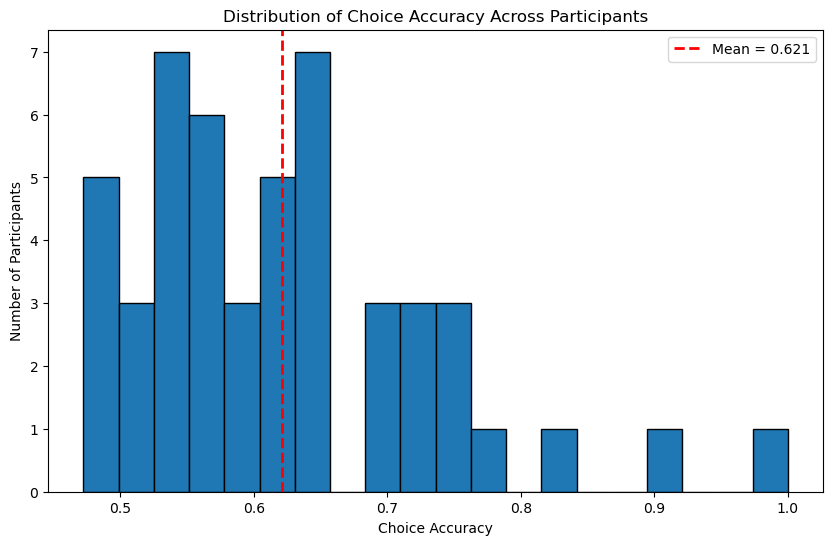

In [69]:
import matplotlib.pyplot as plt

# Extract accuracies into a list
accuracies = [pred['choice_accuracy'] for pred in predictions.values()]

# Create histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=20, edgecolor='black')
plt.xlabel('Choice Accuracy')
plt.ylabel('Number of Participants')
plt.title('Distribution of Choice Accuracy Across Participants')

# Add mean line
plt.axvline(np.mean(accuracies), color='red', linestyle='dashed', linewidth=2, label=f'Mean = {np.mean(accuracies):.3f}')
plt.legend()

plt.show()


[486.10558273 486.14833724 486.09192998 486.09192419 486.31917898
 487.51315539 486.09191681 486.14823818 486.09192971 486.3192214
 486.31928694 486.10545784 486.10560373 487.51530592 486.31923245
 486.1056039  487.51767383 486.09192981 486.31928972 487.41117482
 486.31929778 486.09192998 486.31856855 486.30229021 486.31891179
 486.10557914 486.10559584 486.31928081 486.09193002 486.10560258
 486.14408419 486.14831556 486.09192918 487.51566533 486.31902631
 486.31930816 487.51697999 487.51745848 486.14833777 486.09192818
 486.31930344 486.10527339 486.31401764 486.10454073 486.14775291
 486.31697002 487.51761799 486.10559918 486.09193003 486.09193001
 486.09200074 486.32860937 486.15543053 486.34563498 486.15395825
 486.15544598 487.69511396 486.34760603 486.09200096 486.15533396
 486.10738077 486.09199999 487.69599134 486.09200109 486.34766617
 486.15544538 486.3474343  486.10738092 486.15478815 487.6827609
 486.10737885 486.1073717  486.09199582 486.15544405 486.10700903
 486.1061849

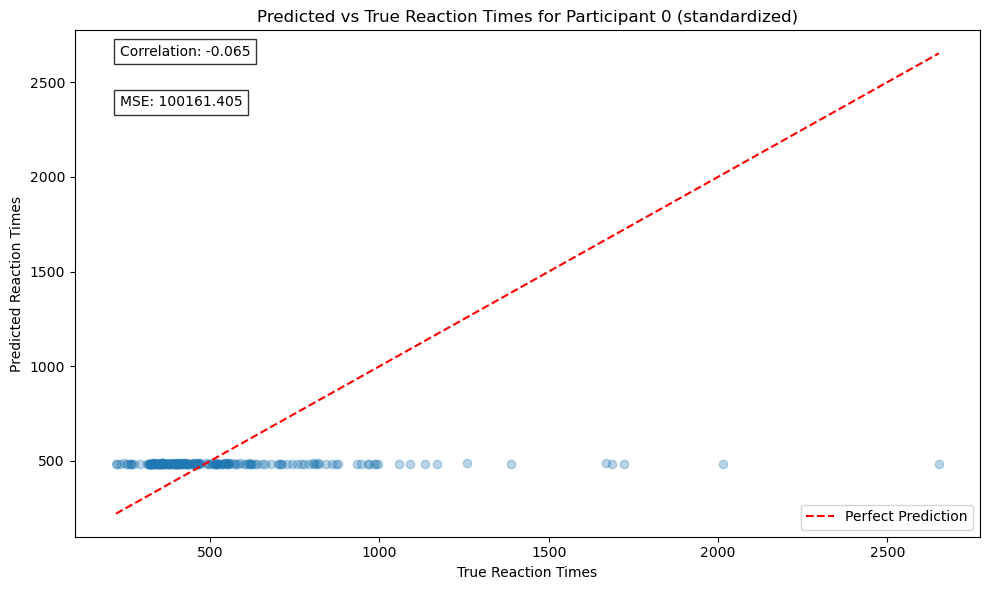

In [70]:
# Create scatter plot of predicted vs true RTs for a single participant
plt.figure(figsize=(10, 6))

# Get first participant's data
participant_id = list(predictions.keys())[0]
pred_rts = predictions[participant_id]['rt_pred'] 
true_rts = predictions[participant_id]['rt_true']

print(pred_rts)

# Create scatter plot
plt.scatter(true_rts, pred_rts, alpha=0.3)

# Add diagonal line representing perfect prediction
min_rt = min(min(true_rts), min(pred_rts))
max_rt = max(max(true_rts), max(pred_rts))
plt.plot([min_rt, max_rt], [min_rt, max_rt], 'r--', label='Perfect Prediction')

plt.xlabel('True Reaction Times')
plt.ylabel('Predicted Reaction Times')
plt.title(f'Predicted vs True Reaction Times for Participant {participant_id} (standardized)')

# Calculate MSE for this participant
mse = np.mean((np.array(true_rts) - np.array(pred_rts))**2)
plt.text(0.05, 0.85, f'MSE: {mse:.3f}', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.legend()

# Add correlation coefficient
correlation = np.corrcoef(true_rts, pred_rts)[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


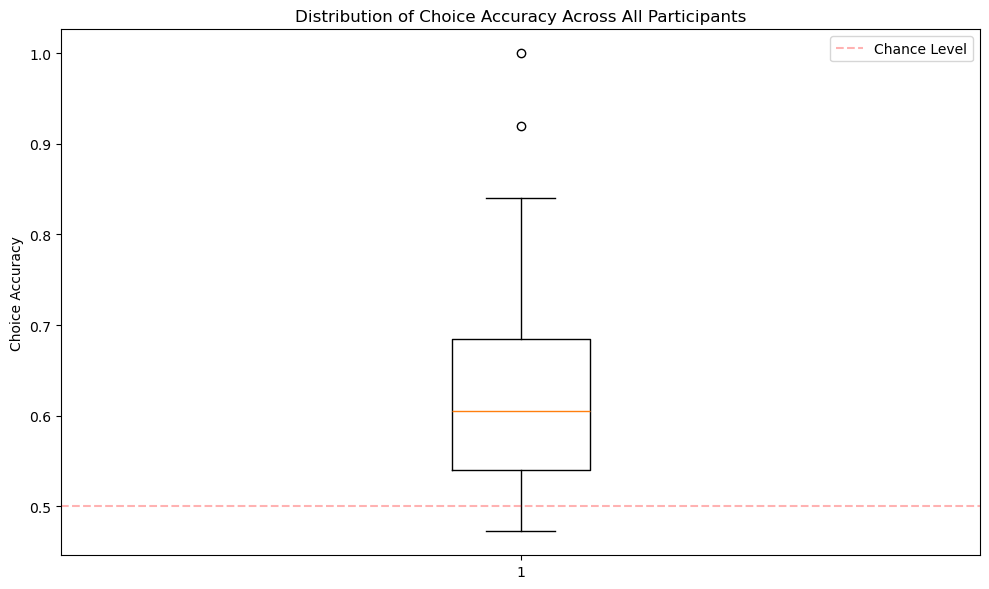

In [71]:
# Create box plot of choice accuracies
plt.figure(figsize=(10, 6))
plt.boxplot([pred['choice_accuracy'] for pred in predictions.values()])
plt.ylabel('Choice Accuracy')
plt.title('Distribution of Choice Accuracy Across All Participants')

# Add horizontal line at 0.5 for chance level
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='Chance Level')
plt.legend()

plt.tight_layout()
plt.show()


/var/folders/xk/kbc85hpn6tjdfbzy5shp_61m0000gn/T/ipykernel_25107/961717223.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(difficulties, labels=[f'P{idx}' for idx in participant_indices])


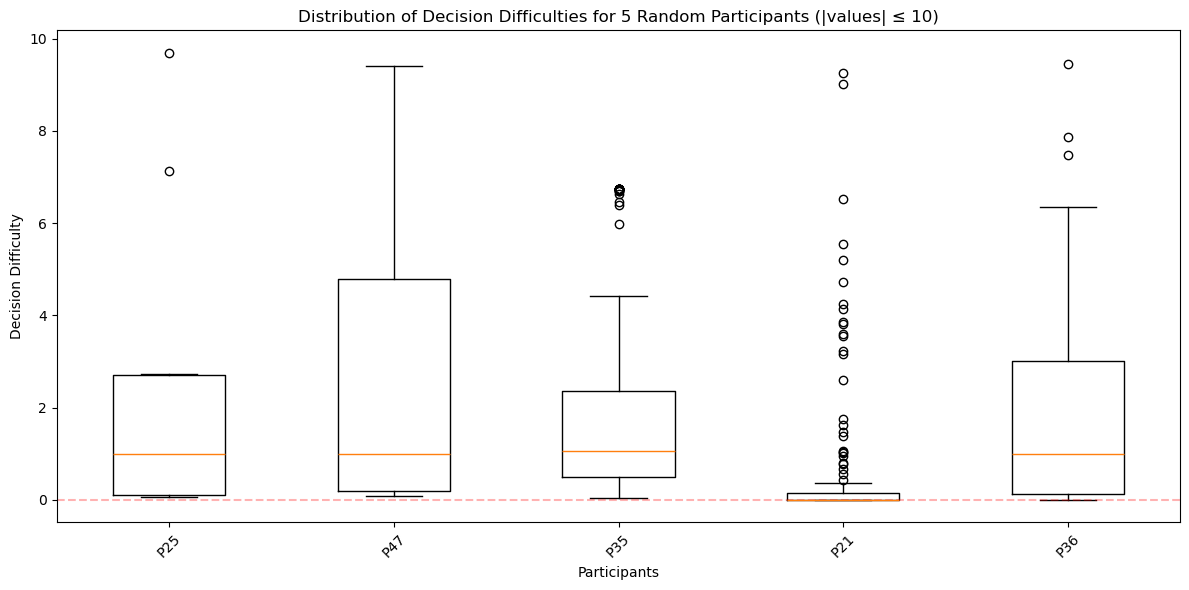

In [72]:
# Extract decision difficulties for each participant and randomly select 5
import random
participant_indices = random.sample(list(decision_difficulty_choice.keys()), 5)
difficulties = [decision_difficulty_choice[idx]['decision_difficulty'] for idx in participant_indices]

# Remove values bigger than 10
difficulties = [[d for d in participant_diffs if abs(d) <= 10] for participant_diffs in difficulties]

# Create box plot
plt.figure(figsize=(12, 6))
plt.boxplot(difficulties, labels=[f'P{idx}' for idx in participant_indices])
plt.xticks(rotation=45)
plt.xlabel('Participants')
plt.ylabel('Decision Difficulty')
plt.title('Distribution of Decision Difficulties for 5 Random Participants (|values| ≤ 10)')

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()
